In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# 0 is best, 2 is worst
def brier(probs, idx_correct):
    tot = sum(probs)
    if tot == 0:
        return 2
    probs = [p/tot for p in probs]
    score = 0
    for i in range(len(probs)):
        expected = int(i == idx_correct) # 1 or 0
        score += (probs[i] - expected) ** 2
    return score

print(brier([100,0,0,0], 0))
print(brier([100,0,0,0], 3))
print(brier([0.1,0.1,0.1,0.7], 3))
print(brier([0.1,0.1,0.1,0.7], 1))
print(brier([0.15,0.15,0.15,0.55], 3))
print(brier([0.15,0.15,0.15,0.55], 1))
print(brier([1,2,3,4],0))

0.0
2.0
0.12000000000000002
1.32
0.26999999999999996
1.0699999999999998
1.1


In [3]:
options = "ABCD"
opt_cols = [f"Probability of {opt}" for opt in options]
pdf = pd.read_csv("players.csv") # player DataFrame
players = dict(pdf.set_index("Email Address")["What do you want your display name to be?"])
gdf = pd.read_csv("guesses.csv") # guess DataFrame
gdf = gdf.drop_duplicates(subset=["Email Address", "Question Number"], keep="first")
adf = pd.read_csv("answers.csv").set_index("qnum") # answer DataFrame
adf["correct_letter"] = adf["correct"].apply(lambda s: s[:1])

In [4]:
def row_brier(row):
    qnum = row["Question Number"]
    if not qnum in adf.index:
        return 2
    correct = adf.loc[qnum, "correct_letter"]
    return brier(list(row[opt_cols]), options.index(correct))

for i in gdf.index:
    gdf.loc[i, "brier"] = row_brier(gdf.loc[i])

In [5]:
def score_user(email, start, end):
    df = gdf[gdf["Email Address"] == email]
    df = df.set_index("Question Number", drop=False)
    score = 0
    for qnum in range(start, end+1):
        score += df.loc[qnum, "brier"] if qnum in df.index else 2
    return score

def score_users(start, end):
    rows = []
    for email, alias in players.items():
        rows.append({"player":alias, "brier":score_user(email, start, end)})
    return pd.DataFrame(rows).sort_values(by="brier")
score_users(1, 1)

,player,brier
19,Stella,0.000000
13,Molly,0.000000
21,missshri,0.013600
10,Jeremy,0.020000
12,Ben Kizaric,0.080000
11,Turner,0.180000
4,Dingyi,0.202479
7,Ian Cheng,0.245000
15,Grant Gilcrease,0.355000
20,Givemegreentea,0.500000


In [30]:
def score_table(start, end):
    df = pd.DataFrame()
    for i in range(start, end+1):
        if i in adf.index:
            df.loc[i, "question"] = adf.loc[i, "question"]
    for i in range(len(gdf)):
        row = gdf.iloc[i]
        email = row["Email Address"]
        qnum = row["Question Number"]
        if email in players and qnum in df.index:
            df.loc[qnum, players[email]] = row["brier"]
    df = df.fillna(2)
    means = df.iloc[:,1:].mean(axis=0)
    df.loc[0, "question"] = "average"
    df.iloc[-1,1:] = means
    return df.sort_index()

with open("scores.html", "w") as f:
    scores = score_table(1, 20)
    scores.round(2).to_html(f)
ranked = scores.iloc[0,1:].sort_values()
print(ranked.mean(), ranked.median())
ranked

0.9034070149021439 0.8771312767022219


Ben Kizaric           0.542
Ian Cheng          0.685207
Turner               0.7325
Stella              0.73367
Megan                  0.78
Givemegreentea        0.791
Dingyi             0.814578
missshri            0.83897
Bryan               0.85842
GAInTheHouse        0.87075
Grant Gilcrease     0.87242
chm                0.881843
Desmond               0.889
Zishan Bai          0.91175
Jeremy                0.927
Andy Lin            0.92792
Molly               0.93275
Wendy               0.94499
RaenonX (Ray)      0.956038
FallGuys            1.07615
Terry               1.12075
Tyler               1.78725
Name: 0, dtype: object

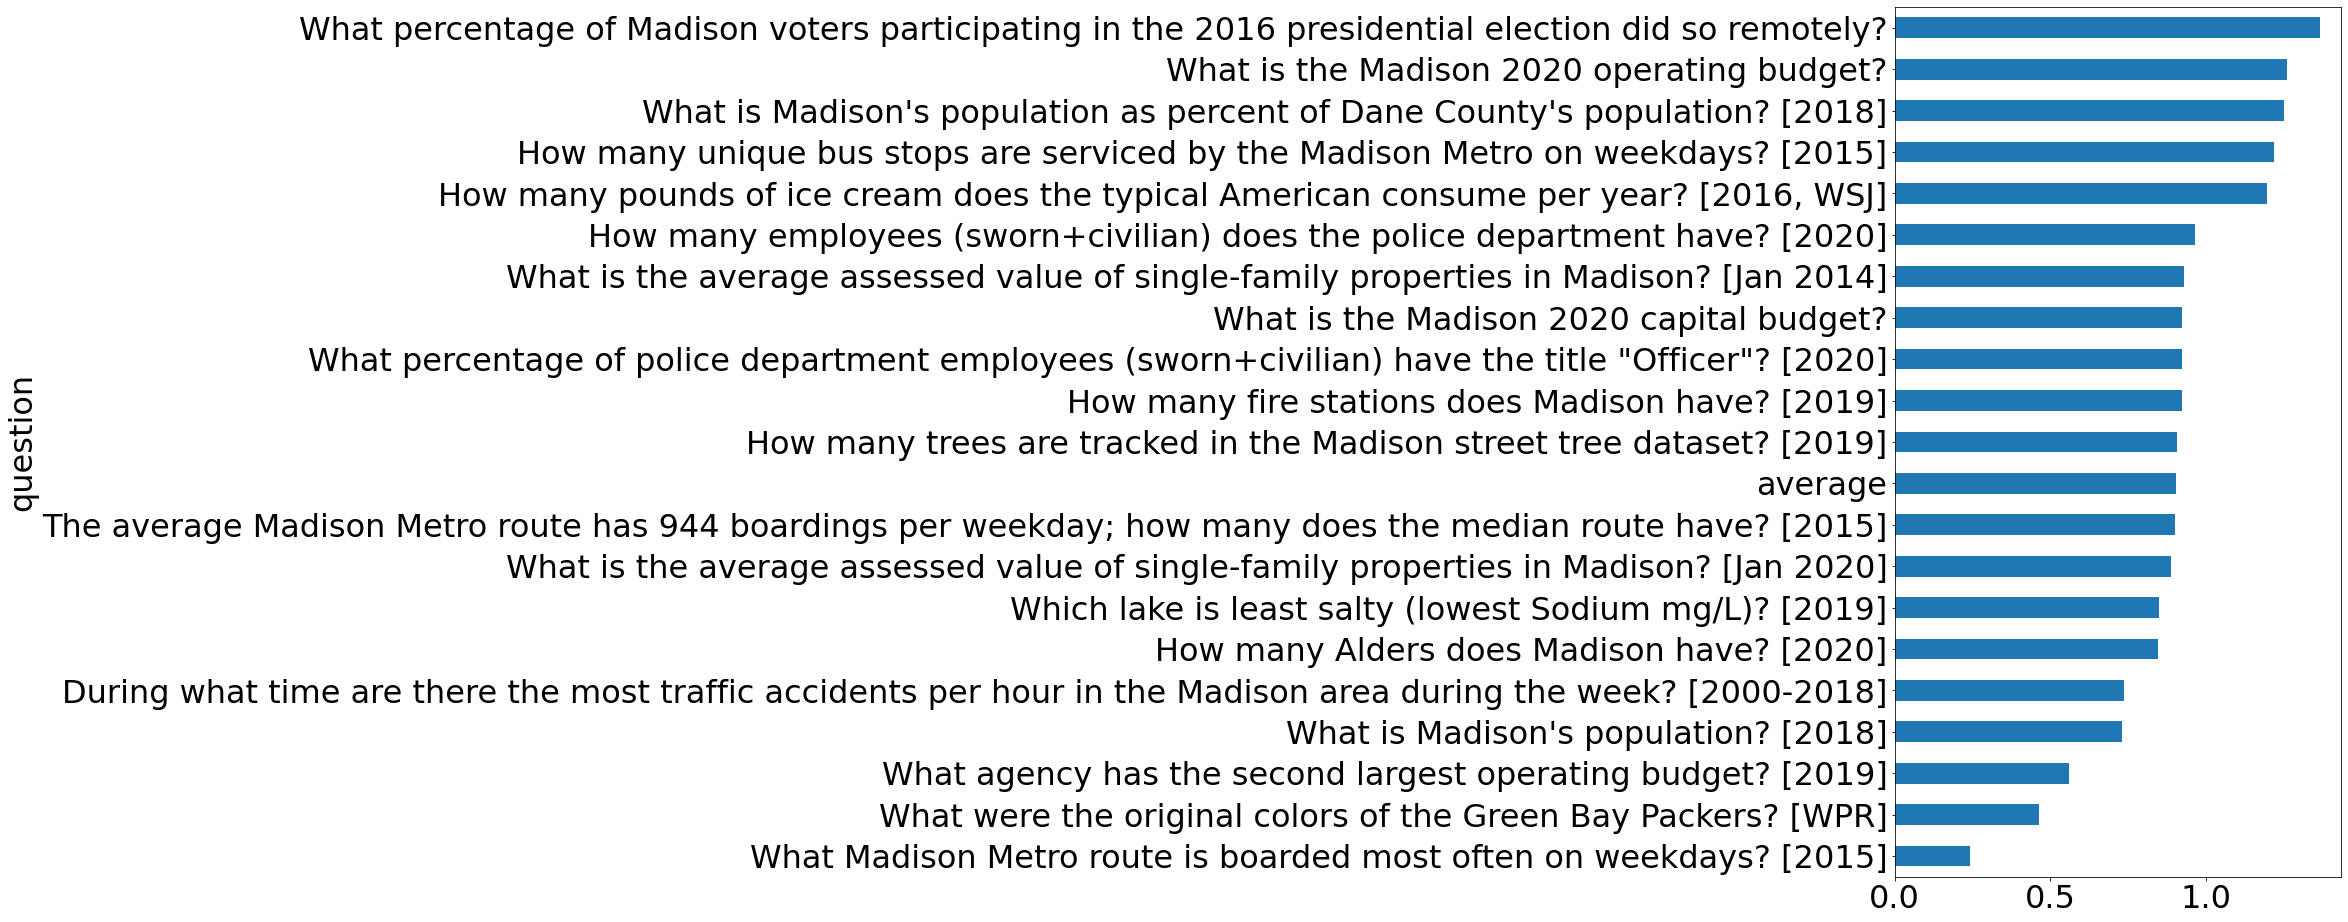

In [7]:
plt.rcParams["font.size"] = 32
scores.set_index("question").mean(axis=1).sort_values().plot.barh(figsize=(8, 16))

Tyler


AttributeError: 'tuple' object has no attribute 'get_figure'

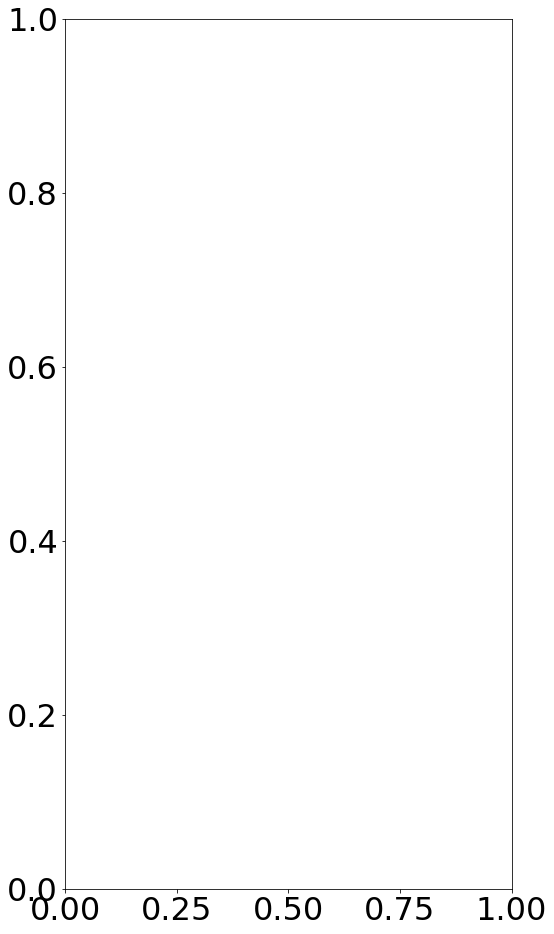

In [23]:
score_tbl = score_table(1,20).set_index("question")
for name in score_tbl.columns:
    print(name)
    ax = plt.subplots(figsize=(8, 16))
    score_tbl[name].sort_values().plot.barh(ax=ax)
    plt.title(name)